<a href="https://colab.research.google.com/github/maha-rw/Handwritten-Digits-Recognition-in-Both-Arabic-and-English/blob/main/Handwritten_Digits_Recognition_Model_1___NN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Handwritten Digits Recognition - Model #1 : Neural Network**

##**Notebook Introduction**
*  This notebook aims to utilize a neural network for the task of recognizing handwritten digits. The objective of this project is to develop a machine learning model that can accurately classify images of handwritten digits into their respective numeric values.


*  This notebook is divided into two main sections:
   1.   Arabic Dataset
   2.   English Dataset



*  both datasets have identical code in hyperparameter tuning but differ in loading the data due to different conditions of datsets files.


*  To run the desired dataset, execute the section dedicated to it.





*   **Used Technique**



In this notebook, we will use the Hyperband technique to tune our Neural Network model's hyperparameters. Hyperband combines random search with early stopping, making it an efficient algorithm for hyperparameter optimization. By iteratively allocating resources to different hyperparameter configurations and discarding poorly performing ones, Hyperband helps us find the best set of hyperparameters within a limited computational budget. Let's leverage the power of Hyperband to fine-tune our Neural Network model and achieve higher performance.

##**import relevent modules**

In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from google.colab import drive
import os
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# **Dataset 1: Arabic Dataset**




Arabic handwritten digits database contains 60,000 training images, and 10,000 test images. MADBase were written by 700 writers. Each writer wrote each digit (from 0 -9) ten times. To ensure including different writing styles, the database was gathered from different institutions: Colleges of Engineering and Law, School of Medicine, the Open University (whose students span a wide range of ages), a high school, and a governmental institution.

find the data here: *https://www.kaggle.com/datasets/mloey1/ahdd1*


**Loading the dataset**

In [ ]:
# Load the data from CSV files
drive.mount('/content/drive')
X_train = pd.read_csv("/content/drive/MyDrive/Handwritten Digits Recognition Project/Group4-Datasets/csvTrainImages 60k x 784.csv").values
Y_train = pd.read_csv("/content/drive/MyDrive/Handwritten Digits Recognition Project/Group4-Datasets/csvTrainLabel 60k x 1.csv").values
X_test = pd.read_csv("/content/drive/MyDrive/Handwritten Digits Recognition Project/Group4-Datasets/csvTestImages 10k x 784.csv").values
Y_test = pd.read_csv("/content/drive/MyDrive/Handwritten Digits Recognition Project/Group4-Datasets/csvTestLabel 10k x 1.csv").values
print (X_train.shape )
print (Y_train.shape)


Mounted at /content/drive
(59999, 784)
(59999, 1)


The input data is currently in a flattened format with 784 pixel values per sample. To prepare the data for image processing tasks, it needs to be **reshaped** into a 3D format, where each sample is represented as a 28x28 image. Reshaping the data allows us to match the expected input shape of models that analyze images

We need to **normalize** the pixel values of the images to a range between 0 and 1. To achieve this, we divide the pixel values by 255, which is the maximum pixel value. Normalization is necessary to ensure that all pixel values are within a consistent and standardized range. This helps the model learn more effectively and improves convergence during training.

In [ ]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Reshape the data
X_train = X_train.reshape(-1, 28, 28)
X_val = X_val.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Print the shapes of the datasets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (47999, 28, 28)
Validation set shape: (12000, 28, 28)
Test set shape: (9999, 28, 28)


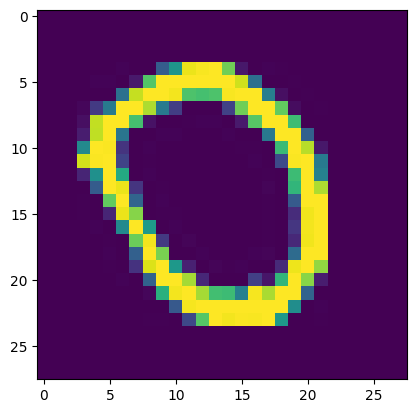

In [ ]:
from matplotlib import pyplot as plt
# Use false colors to visualize the array.
plt.imshow(X_train[2854])


**Hyperparameters Tuning**

In [ ]:
# Define the model builder function
def model_builder(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the following hyperparameters
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_num_layers = hp.Int('num_layers', min_value=0, max_value=5)
    hp_layer_neurons = []
    for i in range(hp_num_layers):
        hp_layer_neurons.append(hp.Int(f'layer_{i+1}_neurons', min_value=1, max_value=1000, step=100))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)
    hp_epochs = hp.Int('epochs', min_value=5, max_value=50, step=5)  # Hyperparameter for the number of epochs

    for neurons in hp_layer_neurons:
        model.add(Dense(units=neurons, activation=hp_activation))
        model.add(Dropout(0.5))  #  dropout layer with a dropout rate of 0.5

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
    return model

In [ ]:
def train_model(model, train_features, train_label, epochs, batch_size=None, validation_split=0.1):
    history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                        epochs=epochs, shuffle=True,
                        validation_split=validation_split)
    hist = pd.DataFrame(history.history)

    return hist

In [ ]:
# Define the stop_early callback
stop_early = EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
# Instantiate the tuner
tunerArabicData2 =  kt.Hyperband(model_builder,
                     objective='val_accuracy', #the metric that the tuner will optimize during this search
                     max_epochs=30,
                     directory='ArabicDatasetTunerDirectory',
                     project_name='ArabicDatasetProject',
                     factor=3)

Reloading Tuner from ArabicDatasetTunerDirectory/ArabicDatasetProject/tuner0.json


In [ ]:
 # Perform hyperparameter search
tunerArabicData2.search(np.array(X_train), np.array(Y_train),
             epochs=30,
             validation_data=(np.array(X_val), np.array(Y_val)),
             callbacks=[stop_early])

Trial 90 Complete [00h 01m 45s]
val_accuracy: 0.9869166612625122

Best val_accuracy So Far: 0.9915000200271606
Total elapsed time: 00h 57m 12s


In [ ]:
# Print the best hyperparameters and their accuracy values
best_hps = tunerArabicData2.get_best_hyperparameters(num_trials=1)[0]
best_hps
hp_epochs = best_hps.get('epochs')

print("Best Hyperparameters:")
print("Activation:", best_hps.get('activation'))
print("Number of Layers:", best_hps.get('num_layers'))
for i in range(best_hps.get('num_layers')):
    layer_idx = i + 1
    layer_key = f'layer_{layer_idx}_neurons'
    print(f"Layer {layer_idx} Neurons:", best_hps.get(layer_key))
print("Learning Rate:", best_hps.get('learning_rate'))
print("Batch Size:", best_hps.get('batch_size'))
print("Epochs:", hp_epochs)

print("Best Accuracy:", tunerArabicData2.oracle.get_best_trials(1)[0].score)

Best Hyperparameters:
Activation: relu
Number of Layers: 3
Layer 1 Neurons: 801
Layer 2 Neurons: 501
Layer 3 Neurons: 201
Learning Rate: 0.0001
Batch Size: 64
Epochs: 25
Best Accuracy: 0.9915000200271606


**Train the Model with the Best Hyperparameters**

In [ ]:
# Build the model with the best hyperparameters
model = model_builder(best_hps)

# Train the model with combined training and validation datasets
hist = train_model(model, np.concatenate([X_train, X_val]), np.concatenate([Y_train, Y_val]),
                   epochs=hp_epochs,
                   batch_size=best_hps.get('batch_size'),
                   validation_split=0.1
                   )

# Extract the training loss and validation loss from the history
train_loss = hist['loss']
val_loss = hist['val_loss']

# Compute the average training loss and validation loss for better visualization
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

# Print the average training loss and validation loss
print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)

Epoch 1/25
844/844 [==============================] - 5s 4ms/step - loss: 0.6737 - accuracy: 0.7941 - val_loss: 0.1438 - val_accuracy: 0.9603
Epoch 2/25
844/844 [==============================] - 3s 4ms/step - loss: 0.1894 - accuracy: 0.9494 - val_loss: 0.1056 - val_accuracy: 0.9705
Epoch 3/25
844/844 [==============================] - 4s 4ms/step - loss: 0.1333 - accuracy: 0.9651 - val_loss: 0.0872 - val_accuracy: 0.9763
Epoch 4/25
844/844 [==============================] - 5s 5ms/step - loss: 0.1067 - accuracy: 0.9719 - val_loss: 0.0732 - val_accuracy: 0.9787
Epoch 5/25
844/844 [==============================] - 3s 4ms/step - loss: 0.0882 - accuracy: 0.9759 - val_loss: 0.0670 - val_accuracy: 0.9807
Epoch 6/25
844/844 [==============================] - 3s 4ms/step - loss: 0.0722 - accuracy: 0.9802 - val_loss: 0.0603 - val_accuracy: 0.9835
Epoch 7/25
844/844 [==============================] - 3s 4ms/step - loss: 0.0614 - accuracy: 0.9832 - val_loss: 0.0587 - val_accuracy: 0.9840
Epoch 

 **Model Evaluation**

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.0681 - accuracy: 0.9869
Test Loss: 0.06805860996246338
Test Accuracy: 0.98689866065979


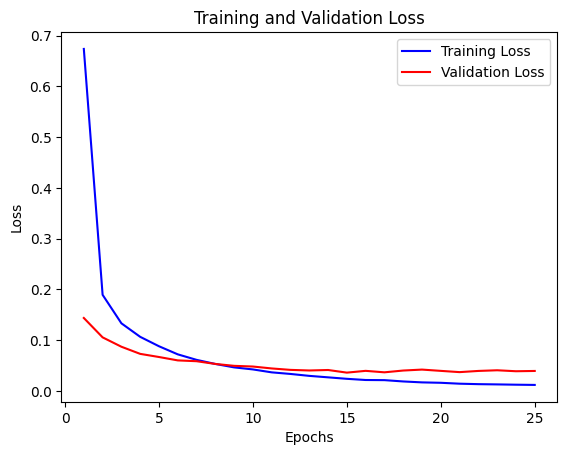

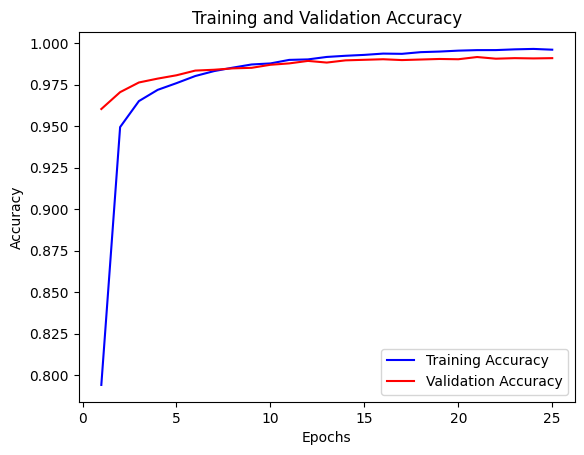

In [ ]:
# Plot the training and validation loss
epochs = range(1, hp_epochs + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('\n\n')
# Plot the training and validation accuracy
train_accuracy = hist['accuracy']
val_accuracy = hist['val_accuracy']
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looking at the above graphs, we can see that there isn't a big gap between the training and validation sets so, we can conclude that overfitting hasn't occured.





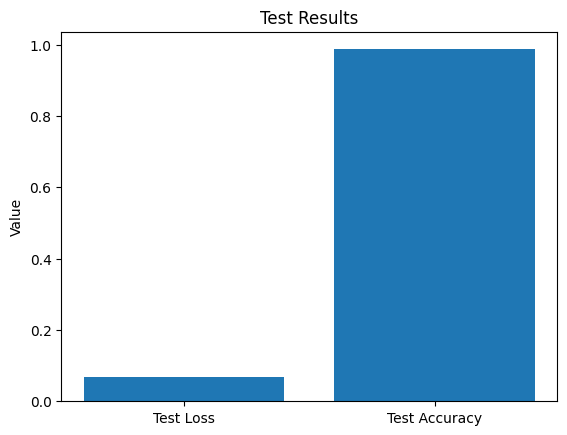

In [ ]:
# Plot the test loss and accuracy
plt.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_accuracy])
plt.title('Test Results')
plt.ylabel('Value')
plt.show()

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy, precision, recall, and F1 score using the classification_report function
classification_report = classification_report(Y_test, y_pred)
print("Classification Report:\n", classification_report)

313/313 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       999
           1       0.99      0.99      0.99      1000
           2       0.97      0.98      0.98      1000
           3       0.99      0.99      0.99      1000
           4       0.99      0.99      0.99      1000
           5       0.98      0.97      0.98      1000
           6       0.99      0.99      0.99      1000
           7       0.99      1.00      1.00      1000
           8       1.00      0.99      1.00      1000
           9       0.99      0.99      0.99      1000

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999



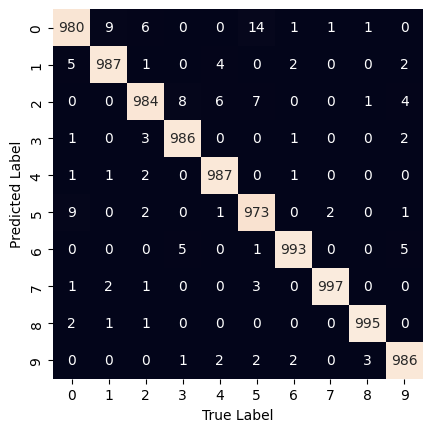

In [ ]:
mat = confusion_matrix(Y_test, y_pred)
sns.heatmap(mat.T , square=True, annot=True, fmt='d', cbar=False,)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

Based on the high values of accuracy, precision, and recall (all close to 0.99), we can conclude that the neural network model performs exceptionally well on the given dataset. The model demonstrates a high level of accuracy in correctly predicting both positive and negative instances, with a precision of 0.99, indicating a low rate of false positives. Additionally, the recall value of 0.99 suggests that the model effectively captures a significant proportion of positive instances from the dataset. These results indicate that the model shows robust performance and can be considered highly reliable for the given task of classifiying handwritten digits images.

In [ ]:
# Reshape the predicted probabilities array
y_pred_probs = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

# Calculate the AUC using the roc_auc_score function
auc = roc_auc_score(Y_test, y_pred_probs, multi_class='ovr')
print("AUC:", auc)

AUC: 0.9995807553488222


AUC = 0.99 means the neural network model is very good at distinguishing between the classes, with a high probability of assigning higher predicted probabilities to true positive instances compared to false positive instances.

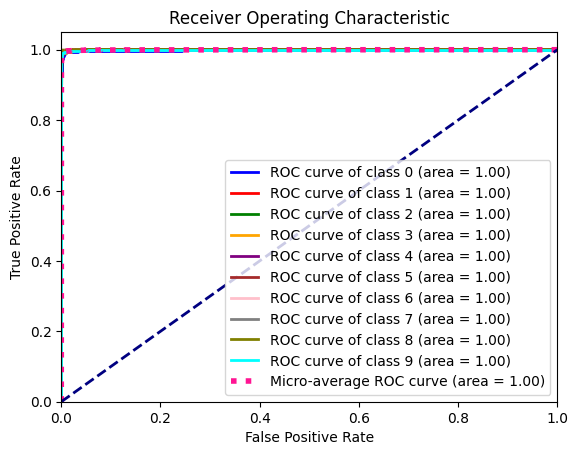

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Reshape the predicted probabilities array
y_pred_probs_reshaped = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

# Convert Y_test to the same data type as y_pred_probs_reshaped
Y_test_reshaped = Y_test.astype(int)

# Ensure both Y_test_reshaped and y_pred_probs_reshaped have the same length
min_length = min(len(Y_test_reshaped), y_pred_probs_reshaped.shape[0])
Y_test_reshaped_trimmed = Y_test_reshaped[:min_length]
y_pred_probs_reshaped_trimmed = y_pred_probs_reshaped[:min_length]

# Convert the true labels to binary format
Y_test_bin = label_binarize(Y_test_reshaped_trimmed, classes=np.arange(y_pred_probs_reshaped_trimmed.shape[1]))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc_values = dict()
for class_idx in range(y_pred_probs_reshaped_trimmed.shape[1]):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(Y_test_bin[:, class_idx], y_pred_probs_reshaped_trimmed[:, class_idx])
    roc_auc_values[class_idx] = auc(fpr[class_idx], tpr[class_idx])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs_reshaped_trimmed.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for class_idx, color in zip(range(y_pred_probs_reshaped_trimmed.shape[1]), colors):
    plt.plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_idx, roc_auc_values[class_idx]))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', lw=4,
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Based on the graph above, the ROC curve's AUC is close to 1, it means the neural network model is doing a great job distinguishing between different groups. It has a low chance of making mistakes (FP) while correctly identifying positives (TP). This suggests the model is strong overall and works well across different scenarios.

In [ ]:
# The tuner hyperband instance of Arabic dataset save its results, including the configuration, checkpoints, and logs in the below directory.
directory_path = 'ArabicDatasetTunerDirectory/ArabicDatasetProject'

if os.path.isdir(directory_path):
    file_list = os.listdir(directory_path)
    for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                content = file.read()
                print(content)
else:
    print(f"Directory '{directory_path}' does not exist or is not a directory.")

{"ongoing_trials": {}, "hyperparameters": {"space": [{"class_name": "Choice", "config": {"name": "activation", "default": "relu", "conditions": [], "values": ["relu", "tanh", "sigmoid"], "ordered": false}}, {"class_name": "Int", "config": {"name": "num_layers", "default": null, "conditions": [], "min_value": 0, "max_value": 5, "step": 1, "sampling": "linear"}}, {"class_name": "Choice", "config": {"name": "learning_rate", "default": 0.01, "conditions": [], "values": [0.01, 0.001, 0.0001], "ordered": true}}, {"class_name": "Int", "config": {"name": "batch_size", "default": null, "conditions": [], "min_value": 32, "max_value": 256, "step": 32, "sampling": "linear"}}, {"class_name": "Int", "config": {"name": "epochs", "default": null, "conditions": [], "min_value": 5, "max_value": 50, "step": 5, "sampling": "linear"}}, {"class_name": "Int", "config": {"name": "layer_1_neurons", "default": null, "conditions": [], "min_value": 1, "max_value": 1000, "step": 100, "sampling": "linear"}}, {"clas

#**Dataset 2: English Dataset**


find the data here: *https://www.kaggle.com/competitions/digit-recognizer/data*


One issue we encountered with the English dataset is that it is divided into two separate files: one for training and one for testing. However, the testing file is missing the corresponding labels, making it impossible to accurately measure the performance of our model without knowing the true values. To address this problem, we have made the decision to utilize only the training set. We will further divide this training set into training, validation, and testing subsets. By doing so, we can overcome the issue of missing labels in the original testing file and ensure that we have reliable performance metrics for evaluating our model's effectiveness. This approach allows us to assess our model's performance accurately.



In [ ]:
# Load the data from CSV files
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Handwritten Digits Recognition Project/Group4-Datasets/E-train.csv')
print (data.shape ) #(42000, 785)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(41995, 785)


The input data is currently in a flattened format with 784 pixel values per sample. To prepare the data for image processing tasks, it needs to be **reshaped** into a 3D format, where each sample is represented as a 28x28 image. Reshaping the data allows us to match the expected input shape of models that analyze images

We need to **normalize** the pixel values of the images to a range between 0 and 1. To achieve this, we divide the pixel values by 255, which is the maximum pixel value. Normalization is necessary to ensure that all pixel values are within a consistent and standardized range. This helps the model learn more effectively and improves convergence during training.

In [ ]:
# Assuming 'data' contains your loaded DataFrame
X = data.drop('label', axis=1)  # Features (input)
y = data['label']  # Labels (output)

# Normalize the image data by dividing by 255
X_normalized = X / 255.0

# Reshape the image data to (-1, 28, 28)
X_reshaped = X_normalized.values.reshape(-1, 28, 28)

# Split the normalized and reshaped data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # Splitting 75% for train and 25% for validation

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (25200, 28, 28)
X_val: (8400, 28, 28)
X_test: (8400, 28, 28)
y_train: (25200,)
y_val: (8400,)
y_test: (8400,)


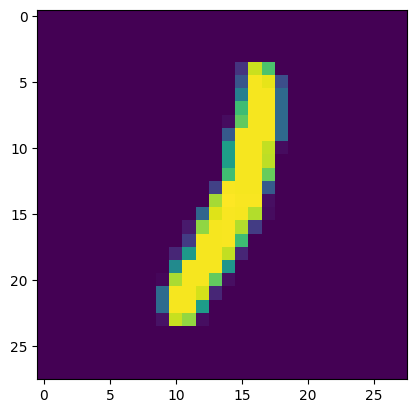

In [ ]:
plt.imshow(X_train[1120])

**Hyperparameters Tuning**

In [ ]:
# Define the model builder function
def model_builder(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the following hyperparameters
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_num_layers = hp.Int('num_layers', min_value=0, max_value=5)
    hp_layer_neurons = []
    for i in range(hp_num_layers):
        hp_layer_neurons.append(hp.Int(f'layer_{i+1}_neurons', min_value=1, max_value=1000, step=100))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)
    hp_epochs = hp.Int('epochs', min_value=5, max_value=50, step=5)  # Hyperparameter for the number of epochs

    for neurons in hp_layer_neurons:
        model.add(Dense(units=neurons, activation=hp_activation))
        model.add(Dropout(0.5))  #  dropout layer with a dropout rate of 0.5

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
    return model

In [ ]:
def train_model(model, train_features, train_label, epochs, batch_size=None, validation_split=0.1):
    history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                        epochs=epochs, shuffle=True,
                        validation_split=validation_split)
    hist = pd.DataFrame(history.history)

    return hist

In [ ]:
# Define the stop_early callback
stop_early = EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
# Instantiate the tuner
tunerEnglishData2 = kt.Hyperband(model_builder,
                     objective='val_accuracy', #the metric that the tuner will optimize during this search
                     max_epochs=30,
                     factor=3,
                    directory='EnglishDatasetTunerDirectory',
                     project_name='EnglishDatasetProject')

In [ ]:
 # Perform hyperparameter search
tunerEnglishData2.search(np.array(X_train), np.array(y_train),
             epochs=30,
             validation_data=(np.array(X_val), np.array(y_val)),
             callbacks=[stop_early])


Trial 90 Complete [00h 00m 26s]
val_accuracy: 0.9469047784805298

Best val_accuracy So Far: 0.975595235824585
Total elapsed time: 00h 31m 58s


In [ ]:
# Print the best hyperparameters and their accuracy values
best_hps = tunerEnglishData2.get_best_hyperparameters(num_trials=1)[0]
best_hps
hp_epochs = best_hps.get('epochs')

print("Best Hyperparameters:")
print("Activation:", best_hps.get('activation'))
print("Number of Layers:", best_hps.get('num_layers'))
for i in range(best_hps.get('num_layers')):
    layer_idx = i + 1
    layer_key = f'layer_{layer_idx}_neurons'
    print(f"Layer {layer_idx} Neurons:", best_hps.get(layer_key))
print("Learning Rate:", best_hps.get('learning_rate'))
print("Batch Size:", best_hps.get('batch_size'))
print("Epochs:", hp_epochs)

print("Best Accuracy:", tunerEnglishData2.oracle.get_best_trials(1)[0].score)

Best Hyperparameters:
Activation: sigmoid
Number of Layers: 3
Layer 1 Neurons: 801
Layer 2 Neurons: 301
Layer 3 Neurons: 601
Learning Rate: 0.001
Batch Size: 160
Epochs: 35
Best Accuracy: 0.975595235824585


**Train the Model with the Best Hyperparameters**

In [ ]:
# Build the model with the best hyperparameters
model = model_builder(best_hps)

# Train the model with combined training and validation datasets
hist = train_model(model, np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]),
                   epochs=hp_epochs,
                   batch_size=best_hps.get('batch_size'),
                   validation_split=0.1
                   )

# Extract the training loss and validation loss from the history
train_loss = hist['loss']
val_loss = hist['val_loss']

# Compute the average training loss and validation loss for better visualization
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

# Print the average training loss and validation loss
print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)

Epoch 1/35
189/189 [==============================] - 2s 5ms/step - loss: 1.2468 - accuracy: 0.5685 - val_loss: 0.3967 - val_accuracy: 0.8824
Epoch 2/35
189/189 [==============================] - 1s 4ms/step - loss: 0.4267 - accuracy: 0.8689 - val_loss: 0.2878 - val_accuracy: 0.9125
Epoch 3/35
189/189 [==============================] - 1s 4ms/step - loss: 0.3349 - accuracy: 0.8997 - val_loss: 0.2467 - val_accuracy: 0.9223
Epoch 4/35
189/189 [==============================] - 1s 4ms/step - loss: 0.2774 - accuracy: 0.9163 - val_loss: 0.2071 - val_accuracy: 0.9372
Epoch 5/35
189/189 [==============================] - 1s 4ms/step - loss: 0.2427 - accuracy: 0.9268 - val_loss: 0.1882 - val_accuracy: 0.9429
Epoch 6/35
189/189 [==============================] - 1s 4ms/step - loss: 0.2117 - accuracy: 0.9366 - val_loss: 0.1646 - val_accuracy: 0.9536
Epoch 7/35
189/189 [==============================] - 1s 4ms/step - loss: 0.1913 - accuracy: 0.9416 - val_loss: 0.1546 - val_accuracy: 0.9542
Epoch 

 **Model Evaluation**

In [ ]:
y_test = y_test.astype(float)
X_test = X_test.astype(float)
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

263/263 [==============================] - 1s 2ms/step - loss: 0.0865 - accuracy: 0.9754
Test Loss: 0.08650675415992737
Test Accuracy: 0.9753571152687073


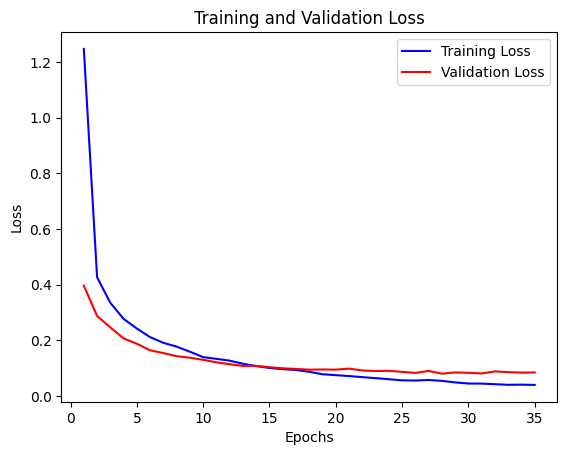

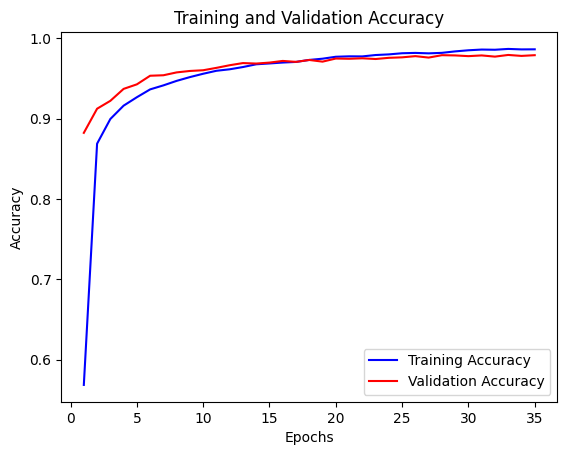

In [ ]:
# Plot the training and validation loss
epochs = range(1, hp_epochs + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('\n\n')
# Plot the training and validation accuracy
train_accuracy = hist['accuracy']
val_accuracy = hist['val_accuracy']
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looking at the above graphs, we can see that there isn't a big gap between the training and validation sets so, we can conclude that overfitting hasn't occured.





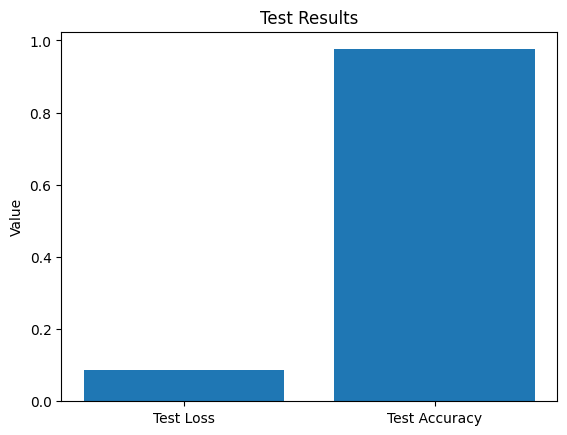

In [ ]:
# Plot the test loss and accuracy
plt.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_accuracy])
plt.title('Test Results')
plt.ylabel('Value')
plt.show()

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_test = y_test.astype(int)

# Ensure both y_test and y_pred have the same length
min_length = min(len(y_test), len(y_pred))
y_test_trimmed = y_test[:min_length]
y_pred_trimmed = y_pred[:min_length]

# Calculate the classification report
classification_report_result = classification_report(y_test_trimmed, y_pred_trimmed)

# Display the classification report
print("Classification Report:\n ", classification_report_result)

263/263 [==============================] - 2s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       0.99      0.99      0.99       909
           2       0.98      0.98      0.98       846
           3       0.96      0.97      0.97       937
           4       0.98      0.97      0.98       839
           5       0.98      0.96      0.97       702
           6       0.97      0.99      0.98       785
           7       0.98      0.98      0.98       893
           8       0.99      0.96      0.97       835
           9       0.96      0.97      0.97       838

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



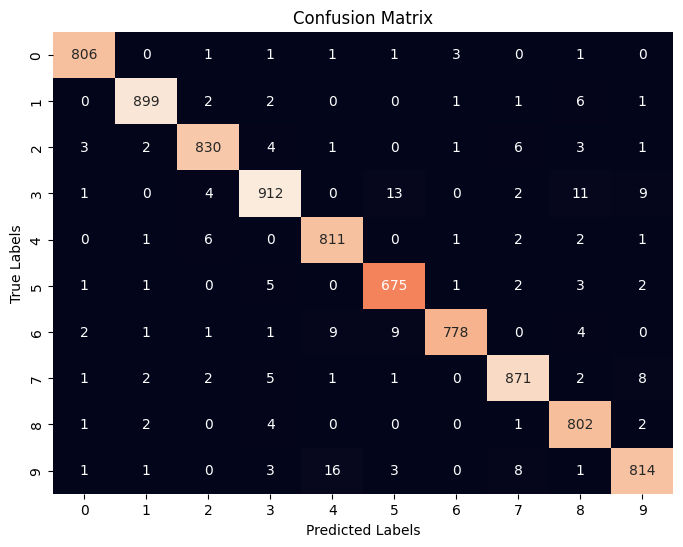

In [ ]:
mat = confusion_matrix(y_test_trimmed, y_pred_trimmed)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Based on the high values of accuracy, precision, and recall (0.98), we can conclude that the neural network model performs exceptionally well on the given dataset. The model demonstrates a high level of accuracy in correctly predicting both positive and negative instances, with a precision of 0.98, indicating a low rate of false positives. Additionally, the recall value of 0.98 suggests that the model effectively captures a significant proportion of positive instances from the dataset. These results indicate that the model shows robust performance and can be considered highly reliable for the given task of classifiying handwritten digits images.

In [ ]:
y_pred_probs_reshaped = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

# Convert y_test to the same data type as y_pred_probs_reshaped
y_test_reshaped = y_test.astype(int)

# Ensure both y_test_reshaped and y_pred_probs_reshaped have the same length
min_length = min(len(y_test_reshaped), y_pred_probs_reshaped.shape[0])
y_test_reshaped_trimmed = y_test_reshaped[:min_length]
y_pred_probs_reshaped_trimmed = y_pred_probs_reshaped[:min_length]

# Calculate the AUC using the roc_auc_score function
auc = roc_auc_score(y_test_reshaped_trimmed, y_pred_probs_reshaped_trimmed, multi_class='ovr')
print("AUC:", auc)

AUC: 0.9995897103759678


AUC = 0.99 means the neural network model is very good at distinguishing between the classes, with a high probability of assigning higher predicted probabilities to true positive instances compared to false positive instances.

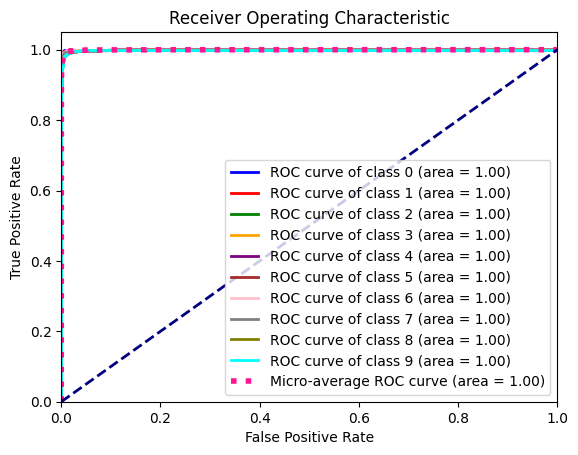

In [ ]:
y_pred_probs_reshaped = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

# Convert y_test to the same data type as y_pred_probs_reshaped
y_test_reshaped = y_test.astype(int)

# Ensure both y_test_reshaped and y_pred_probs_reshaped have the same length
min_length = min(len(y_test_reshaped), y_pred_probs_reshaped.shape[0])
y_test_reshaped_trimmed = y_test_reshaped[:min_length]
y_pred_probs_reshaped_trimmed = y_pred_probs_reshaped[:min_length]

# Convert the true labels to binary format
y_test_bin = label_binarize(y_test_reshaped_trimmed, classes=np.arange(y_pred_probs_reshaped_trimmed.shape[1]))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_idx in range(y_pred_probs_reshaped_trimmed.shape[1]):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_test_bin[:, class_idx], y_pred_probs_reshaped_trimmed[:, class_idx])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_probs_reshaped_trimmed.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for class_idx, color in zip(range(y_pred_probs_reshaped_trimmed.shape[1]), colors):
    plt.plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_idx, roc_auc[class_idx]))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', lw=4,
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Based on the graph above, the ROC curve's AUC is close to 1, it means the neural network model is doing a great job distinguishing between different groups. It has a low chance of making mistakes (FP) while correctly identifying positives (TP). This suggests the model is strong overall and works well across different scenarios.

In [ ]:
# The tuner hyperband instance of English dataset save its results, including the configuration, checkpoints, and logs in the below directory.
directory_path = 'EnglishDatasetTunerDirectory/EnglishDatasetProject'

if os.path.isdir(directory_path):
    file_list = os.listdir(directory_path)
    for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                content = file.read()
                print(content)
else:
    print(f"Directory '{directory_path}' does not exist or is not a directory.")

{"ongoing_trials": {}, "hyperparameters": {"space": [{"class_name": "Choice", "config": {"name": "activation", "default": "relu", "conditions": [], "values": ["relu", "tanh", "sigmoid"], "ordered": false}}, {"class_name": "Int", "config": {"name": "num_layers", "default": null, "conditions": [], "min_value": 0, "max_value": 5, "step": 1, "sampling": "linear"}}, {"class_name": "Choice", "config": {"name": "learning_rate", "default": 0.01, "conditions": [], "values": [0.01, 0.001, 0.0001], "ordered": true}}, {"class_name": "Int", "config": {"name": "batch_size", "default": null, "conditions": [], "min_value": 32, "max_value": 256, "step": 32, "sampling": "linear"}}, {"class_name": "Int", "config": {"name": "epochs", "default": null, "conditions": [], "min_value": 5, "max_value": 50, "step": 5, "sampling": "linear"}}, {"class_name": "Int", "config": {"name": "layer_1_neurons", "default": null, "conditions": [], "min_value": 1, "max_value": 1000, "step": 100, "sampling": "linear"}}, {"clas

# **Summary**


In summary, our Neural Network (NN) model performed well on both datasets, with the Arabic dataset showing better results compared to the English dataset. This difference might be due to factors like the size or diversity of the English dataset. Additionally, encountering an issue where test labels were missing in the English dataset led us to rely on the training dataset for both training and testing, reducing the number of training examples and potentially contributing to having worse results for the English dataset. To further enhance our results, we intend to explore alternative models such as Random Forest and Support Vector Machines (SVM). Experimenting with different models aims to improve overall performance and deepen our understanding of the data patterns. These efforts will refine our approach and optimize the effectiveness of our models for the given task.





